# Part 2 : Business Analysis

## Summary

Note: In the assignment it mentions that the lending club data is from 2007-2015, but there is more 
data available in the attached data set.  Sense including the more recent loan data has no bearing on
the results for the 2007-2017 time period, I will keep them included for the sake of completeness

In [1]:
cd ../

/Users/fbales138/Git/loan_analysis


In [2]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import datetime
import random
from IPython.display import Image


# Data Processing and Filtering

##### Import the Processed Loan Data

In [3]:
loan_data = pd.read_csv('data/loan.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
for date_col in ['last_pymnt_d','issue_d']:
    loan_data[date_col] = pd.to_datetime(loan_data[date_col],format='%b-%Y')

In [5]:
present_date = max(loan_data['last_pymnt_d'].max(),loan_data['issue_d'].max())

I am filtering out the loans which do not have atleast 36 months of data on them.
I am also converting the loan term to an int so that I can filter for loans that have reached maturity

In [6]:
# Removing all loans that are not 36 mo term
loan_data['term'] = loan_data['term'].str.strip()
loan_data['term_months'] = loan_data['term'].str[:2].astype(int)
loan_data = loan_data.loc[loan_data['term_months']==36]

In [7]:
# Removing all loans with less than 36 mo of data
def get_date_diff_mo(early_date,later_date):
    date_delta = relativedelta(later_date, early_date)
    duration_mo = date_delta.years*12 + date_delta.months
    return duration_mo

loan_data['loan_data_mo'] = loan_data['issue_d'].apply(lambda x: get_date_diff_mo(x,present_date))
loan_data = loan_data.loc[loan_data['loan_data_mo']>=36]

In [8]:
loan_data.loan_status.value_counts()

Fully Paid                                             573143
Charged Off                                             93301
Current                                                  2899
Does not meet the credit policy. Status:Fully Paid       1789
Does not meet the credit policy. Status:Charged Off       649
Late (31-120 days)                                        498
In Grace Period                                           118
Late (16-30 days)                                          56
Name: loan_status, dtype: int64

In [9]:
loan_data.int_rate.describe()

count    672453.000000
mean         11.951003
std           3.863733
min           5.320000
25%           8.900000
50%          11.990000
75%          14.330000
max          28.990000
Name: int_rate, dtype: float64

In [11]:
#completed_loan_status_list = ['Fully Paid','Charged Off','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Default']
fully_paid_list = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']

## Rate of Return Calculations

In [12]:
# Calculate the number of months a loan was repayed - will be 36 
def calculate_loan_repayment_duration(x):
    if x['loan_status'] in [fully_paid_list]:
        payment_duration = 36
    else:
        payment_duration = get_date_diff_mo(x['issue_d'],x['last_pymnt_d'])
    return payment_duration

loan_data = loan_data.dropna(subset=['last_pymnt_d'])
loan_data['payment_duration'] = loan_data.apply(calculate_loan_repayment_duration,axis=1)

In [13]:
loan_data['payment_duration'].describe()

count    671907.000000
mean         24.560485
std          11.110220
min           0.000000
25%          15.000000
50%          26.000000
75%          36.000000
max          70.000000
Name: payment_duration, dtype: float64

In order to compute the rate of return, I am going to utilize a formula I found in the Lending Club website called
Net Annualized Return (https://www.lendingclub.com/public/lendersPerformanceHelpPop.action).  The Formula is as follows:

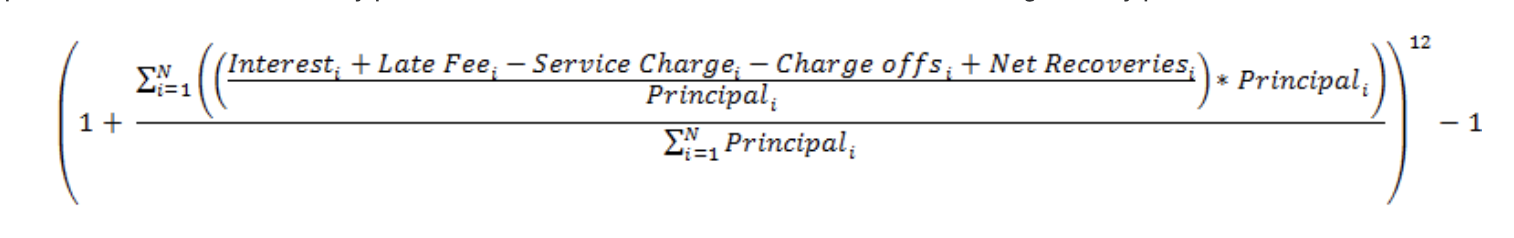

In [14]:
Image('data/nas_formula.png')

In [15]:
loan_data[['total_rec_int','total_rec_late_fee','total_pymnt_inv','funded_amnt','total_rec_prncp','recoveries','collection_recovery_fee','funded_amnt','payment_duration']].isnull().sum()

total_rec_int              0
total_rec_late_fee         0
total_pymnt_inv            0
funded_amnt                0
total_rec_prncp            0
recoveries                 0
collection_recovery_fee    0
funded_amnt                0
payment_duration           0
dtype: int64

In [16]:
def compute_nas(x):
    interest = x['total_rec_int']
    late_fee = x['total_rec_late_fee']
    service_charge = 0.01*x['total_pymnt_inv']
    charge_off = x['funded_amnt'] - x['total_rec_prncp']
    net_recovery = x['recoveries']-x['collection_recovery_fee']
    principal = x['funded_amnt']
    if x['payment_duration'] == 0:
        time=12
    else:
        time = 12/x['payment_duration']
    nas = (1+(interest + late_fee - service_charge - charge_off + net_recovery)/principal)**time-1
    return nas

In [18]:
loan_data['net_annualized_return'] = loan_data.apply(compute_nas,axis=1)

In [19]:
loan_data['net_annualized_return'].describe()

count    671907.000000
mean          0.004248
std           0.204817
min          -1.000000
25%           0.037008
50%           0.058251
75%           0.081055
max           2.085378
Name: net_annualized_return, dtype: float64

In [20]:
completed_loans_nar_mean = loan_data['net_annualized_return'].mean()
completed_loans_nar_median = loan_data['net_annualized_return'].median()

print(f'Completed Loans Mean Net Annualized Return: {round(completed_loans_nar_mean*100,2)}%, Completed Loans Median Net Annualized Return: {round(completed_loans_nar_median*100,2)}% ')

Completed Loans Mean Net Annualized Return: 0.42%, Completed Loans Median Net Annualized Return: 5.83% 


In [22]:
nar_by_grade_df = loan_data.groupby([loan_data['issue_d'].dt.year,'grade']).agg({'net_annualized_return':['mean','median']}).sort_index()
nar_by_sub_grade_df = loan_data.groupby([loan_data['issue_d'].dt.year,'sub_grade']).agg({'net_annualized_return':['mean','median']}).sort_index()

In [25]:
nar_by_grade_df.sort_values(by=('net_annualized_return','mean'),ascending=False)

net_annualized_return          
                               mean    median
issue_d grade                                
2007    A                  0.038871  0.040366
2013    B                  0.027730  0.063466
2012    G                  0.027238  0.133366
2013    A                  0.024691  0.040937
2008    A                  0.022839  0.042625
2014    B                  0.022407  0.060325
2013    C                  0.022296  0.081696
2014    A                  0.021219  0.039360
2010    A                  0.018709  0.035905
2015    A                  0.016473  0.035905
2009    A                  0.013642  0.043788
2016    A                  0.013253  0.034792
2010    B                  0.012421  0.053753
2013    D                  0.012052  0.095854
2011    B                  0.010925  0.056185
2012    B                  0.010273  0.063466
2013    E                  0.009561  0.109524
2014    C                  0.007952  0.073506
2012    E                  0.007783  0.105192
2015    B                  0.007651  0.053201
2012    A                  0.006491  0.037728
2011    A                  0.005946  0.034920
2010    C                  0.005729  0.067555
2016    B                  0.003691  0.052431
2012    F                  0.003282  0.114632
        D                  0.002690  0.091929
        C                  0.002592  0.077365
2011    D                  0.002577  0.080245
        E                 -0.001491  0.091971
        C                 -0.002402  0.069337
...                             ...       ...
2016    C                 -0.021339  0.069319
2014    F                 -0.022740  0.119307
2008    B                 -0.033523  0.052040
2007    B                 -0.034902  0.047965
2009    E                 -0.036263  0.081669
2015    D                 -0.036559  0.084417
2009    G                 -0.040662  0.097323
        F                 -0.045871  0.091170
2008    C                 -0.046990  0.059268
2014    G                 -0.048933  0.127503
2007    C                 -0.050741  0.054865
2016    D                 -0.054251  0.087448
2008    E                 -0.056820  0.073926
2010    F                 -0.064322  0.091202
2015    E                 -0.068330  0.093726
2008    G                 -0.074527  0.089760
2007    D                 -0.076441  0.063351
2013    G                 -0.079379  0.127190
2007    E                 -0.082123  0.069671
2008    D                 -0.082972  0.066526
2016    E                 -0.091617  0.097850
2011    G                 -0.095098  0.096826
2015    F                 -0.105703  0.110065
2010    G                 -0.106151  0.099545
2008    F                 -0.119295  0.079673
2016    F                 -0.130925  0.112841
2007    G                 -0.135260  0.084524
2016    G                 -0.157412  0.133383
2015    G                 -0.164084  0.121563
2007    F                 -0.205276  0.072977

[70 rows x 2 columns]

In [26]:
nar_by_sub_grade_df.sort_values(by=('net_annualized_return','mean'),ascending=False)

net_annualized_return          
                                   mean    median
issue_d sub_grade                                
2012    G3                     0.161444  0.161444
        G4                     0.160867  0.161363
        G2                     0.145000  0.122362
2016    G4                     0.131688  0.143477
2011    F3                     0.125661  0.137692
2016    G3                     0.122470  0.138223
2012    F4                     0.118202  0.117027
2011    F4                     0.116824  0.112214
        G4                     0.097659  0.097659
2012    F2                     0.095998  0.114634
2010    G4                     0.067606  0.104624
2007    A4                     0.047867  0.040774
2010    E4                     0.046350  0.091141
2007    A5                     0.042980  0.046072
2008    A2                     0.040955  0.039361
2007    A2                     0.040853  0.037762
2012    G5                     0.036442  0.162373
2007    A1                     0.035338  0.034773
2008    A1                     0.035210  0.036990
2009    A3                     0.031223  0.038348
2013    B3                     0.028778  0.061378
        B2                     0.028487  0.056663
        B4                     0.028057  0.067030
        C2                     0.027371  0.076730
2012    E1                     0.026985  0.100667
2007    B4                     0.026981  0.048279
2013    A3                     0.026940  0.039373
        B1                     0.026503  0.051546
        C1                     0.026458  0.073199
        A5                     0.026430  0.045892
...                                 ...       ...
2016    F2                    -0.141847  0.111107
2008    G3                    -0.143902  0.089395
2015    G3                    -0.149915  0.108931
2016    F4                    -0.152150  0.118278
2008    F2                    -0.154657  0.078121
2007    C5                    -0.155716  0.057844
2015    G1                    -0.162967  0.123181
2010    F3                    -0.166892  0.090786
2016    G2                    -0.169021  0.136601
2007    F1                    -0.169338  0.072977
2015    F5                    -0.174027  0.060259
2016    E5                    -0.176421  0.102630
2007    G4                    -0.181313  0.017835
2010    G3                    -0.187017  0.098426
2009    E4                    -0.189792  0.081082
2015    G2                    -0.190758  0.111307
2014    G4                    -0.203121  0.029440
2007    F4                    -0.207290  0.080608
2014    G5                    -0.212109  0.128484
2016    F5                    -0.233989 -0.059305
2010    G5                    -0.243888 -0.004286
2007    F5                    -0.254570 -0.118218
2008    F4                    -0.260896 -0.034442
2007    G2                    -0.283855 -0.323611
2016    G1                    -0.324325 -0.055802
2007    F3                    -0.358569 -0.292525
2015    G5                    -0.454442 -0.532618
2011    G5                    -0.483541 -0.483541
2012    G1                    -0.612103 -0.856040
2013    G3                    -0.948274 -0.948274

[347 rows x 2 columns]